### 2019 SG401 - Oculus Glider (Quick Look)

- Data is hosted on Pavlof (netcdf) and downdraft (erddap)

- Deployed from Dyson at:
    + Data Prior to April 20th is test data from Puget Sound   

- Hit M8 at dive 812 (~May 12 at 00:00)

--
Tested with Python >= 3.6

In [13]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import GliderDataLoader
import cmocean
import numpy as np
import pandas as pd
import datetime

In [14]:
sg401=GliderDataLoader.erddap_glider('sg401')
sg401.list_data(verbose=True)

0     sg401_2019_aanderaa
1      sg401_2019_wetlabs
2      sg401_EcoFOCI_2019
3    sg401_b9ae_ed68_1861
Name: Dataset ID, dtype: object


In [15]:
variables = {'sg401_EcoFOCI_2019':[
                     'dive_number',
                     'latitude', 
                     'ctd_depth', 
                     'longitude', 
                     'salinity',
                     'density', 
                     'time', 
                     'temperature'],
                     'sg401_2019_wetlabs':['time',
                     'wlbb2fl_FL1sig',
                     'wlbb2fl_sig695nm_adjusted',
                     'wlbb2fl_sig470nm_adjusted', 
                     'wlbb2fl_sig700nm_adjusted', 
                     'wlbb2fl_temp',
                     'profileid_wetlabs'],
                     'sg401_2019_aanderaa':['time',
                     'aanderaa4330_dissolved_oxygen',
                     'aa4330_airsat',
                     'aa4330_temp']}
#sg401.constrain_data(start_date='2019-04-18T00:00:00Z',variables=variables)
sg401.constrain_data(start_date=(datetime.datetime.today()-datetime.timedelta(days=1)).strftime('%Y-%m-%dT00:00:00Z'),variables=variables)
dfs = sg401.load_data()

sg401_2019_aanderaa
sg401_2019_wetlabs
sg401_EcoFOCI_2019


## Quick Stats/Summary

In [16]:
print("Last run {0}".format(datetime.datetime.now()))
print("Number of Dives: {0}".format(dfs['sg401_EcoFOCI_2019'].dive_number.max()))

Last run 2019-05-17 11:39:55.929337
Number of Dives: 1020


## Timeseries plots
- plot last 7 days of data

In [17]:
daysback=14
data_window = dfs['sg401_EcoFOCI_2019'][(datetime.datetime.today()-\
                                         datetime.timedelta(days=daysback)).strftime('%Y-%m-%d'):]

In [18]:
#calculate diverate
data_window['descent_rate (m/s)'] = data_window['ctd_depth (meters)'].diff()/data_window.index.to_series().diff().dt.seconds

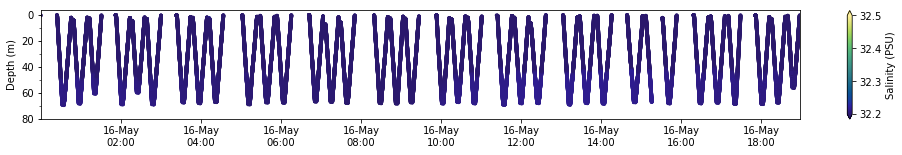

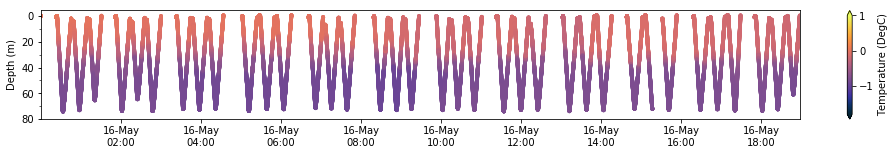

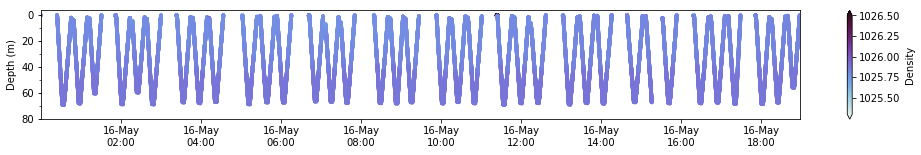

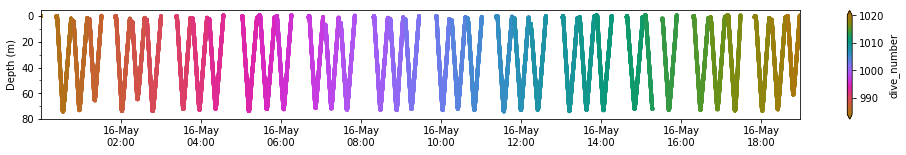

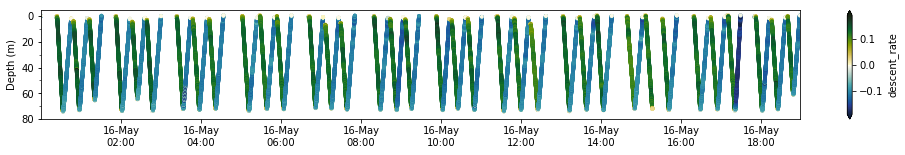

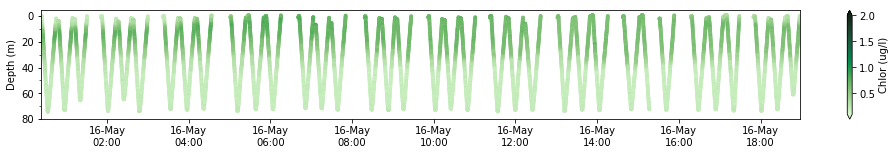

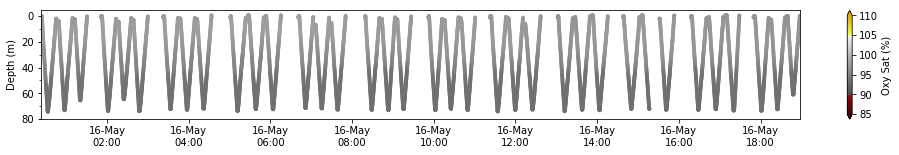

In [19]:
sg401.plot_timeseries(data_window.sort_index(), 'salinity (PSU)','Salinity (PSU)',cmocean.cm.haline,vmin=32.2,vmax=32.5)

sg401.plot_timeseries(data_window.sort_index(), 'temperature (degrees_Celsius)','Temperature (DegC)',vmin=-1.8,vmax=1)

sg401.plot_timeseries(data_window.sort_index(), 'density (g/m^3)','Density',cmocean.cm.dense,vmin=1025.3,vmax=1026.5)

sg401.plot_timeseries(data_window.sort_index(), 'dive_number','dive_number',cmocean.cm.phase)

sg401.plot_timeseries(data_window.sort_index(), 'descent_rate (m/s)','descent_rate',cmocean.cm.delta)

### depth needs to be downsampled to the other database freqencies to plot chlor/oxy

dfwet = dfs['sg401_2019_wetlabs'].join(dfs['sg401_EcoFOCI_2019'])
dfaan = dfs['sg401_2019_aanderaa'].join(dfs['sg401_EcoFOCI_2019'])


#quick QC
dfaan.aa4330_airsat[dfaan.aa4330_airsat < 0] =np.nan
#correct data if calculated isn't available
darkCounts = 47
scaleFactor = 0.012
dfwet['wlbb2fl_FL1sig_mc'] = scaleFactor*(dfwet['wlbb2fl_FL1sig'] - darkCounts)


sg401.plot_timeseries(dfwet[(datetime.datetime.today()-datetime.timedelta(days=daysback)).strftime('%Y-%m-%d'):], 
                      'wlbb2fl_FL1sig_mc','Chlor (ug/l)',cmocean.cm.algae,vmin=0.1,vmax=2)

fig,ax = sg401.plot_timeseries(dfaan[(datetime.datetime.today()-datetime.timedelta(days=daysback)).strftime('%Y-%m-%d'):],
                      'aa4330_airsat','Oxy Sat (%)',cmocean.cm.oxy,vmin=110,vmax=85)

## waterfall plots
- plot last 24 hours of data

In [20]:
data_window = dfs['sg401_EcoFOCI_2019'][(datetime.datetime.today()-datetime.timedelta(days=1)).strftime('%Y-%m-%d'):]

### depth needs to be downsampled to the other database freqencyies to plot chlor/oxy

dfwet = dfs['sg401_2019_wetlabs'].join(data_window)
dfaan = dfs['sg401_2019_aanderaa'].join(data_window)


#quick QC
dfaan.aa4330_airsat[dfaan.aa4330_airsat < 0] =np.nan
#correct data if calculated isn't available
darkCounts = 47
scaleFactor = 0.012
dfwet['wlbb2fl_FL1sig_mc'] = scaleFactor*(dfwet['wlbb2fl_FL1sig'] - darkCounts)



(<Figure size 576x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12dbc3ef0>)

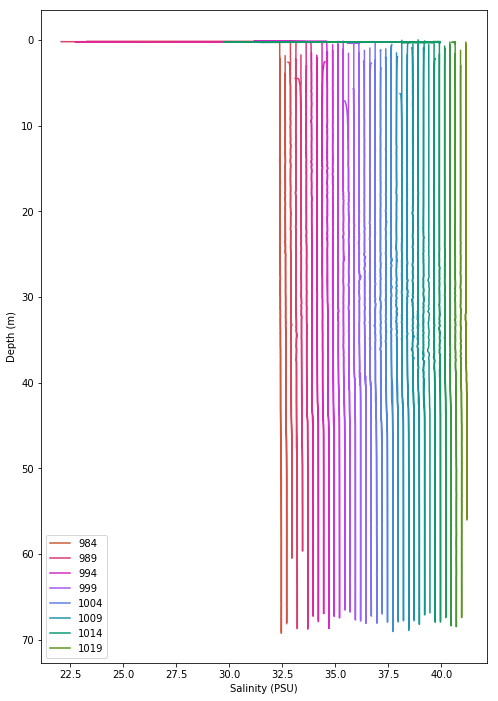

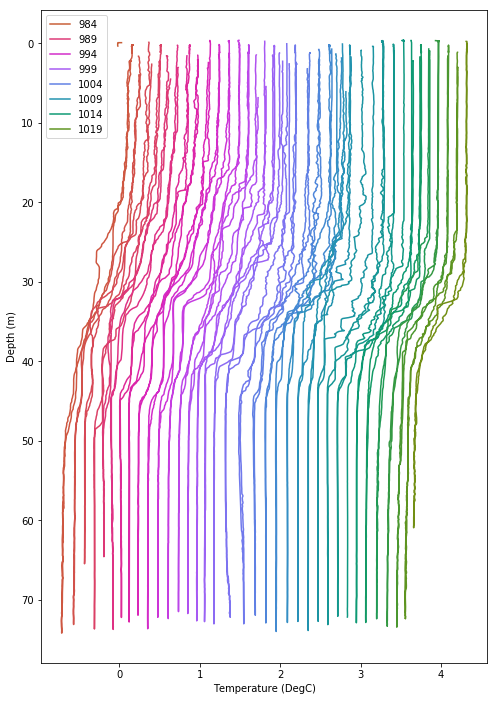

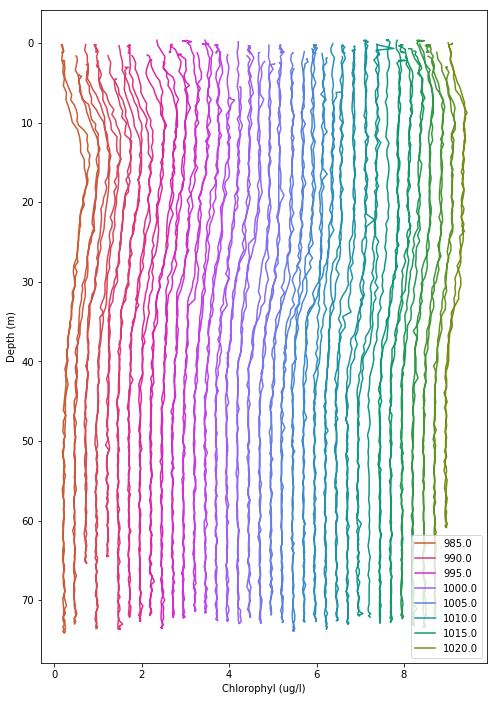

In [21]:
dfg = data_window.groupby('dive_number')
dfwg = dfwet.groupby('dive_number')

sg401.plot_waterfall(dfg, 'salinity (PSU)','Salinity (PSU)',.25)
sg401.plot_waterfall(dfg, 'temperature (degrees_Celsius)','Temperature (DegC)',.125)
sg401.plot_waterfall(dfwg, 'wlbb2fl_FL1sig_mc','Chlorophyl (ug/l)',.25)

## Bottom Data only

In [22]:
dive = dfs['sg401_EcoFOCI_2019'].groupby('dive_number')
bottom = dfs['sg401_EcoFOCI_2019'].loc[dfs['sg401_EcoFOCI_2019'].groupby('dive_number')["ctd_depth (meters)"].idxmax()]
    

In [23]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

#using xarray for bathymetry data read
import xarray as xa

extent=[-180, -155, 55, 66]

server_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSS111'
bathy = xa.open_dataset(server_url) 
bathy_sub = bathy.sel(latitude=slice(extent[3],extent[2]),longitude=slice(extent[0],extent[1]))

#bathy_sub.topo.plot(cmap=cmocean.cm.gray)

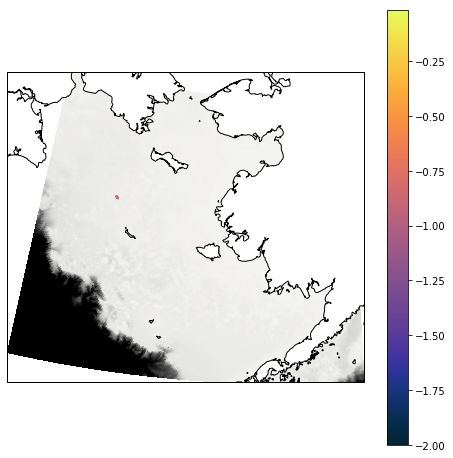

In [24]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8,8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

fig,ax = make_map(projection=projection)

ax.pcolormesh(bathy_sub.longitude, bathy_sub.latitude, 
              bathy_sub.topo, cmap=cmocean.cm.gray,
              vmin=-3000,vmax=100,
              transform=transformation)
c = ax.scatter(bottom['longitude (degrees_east)'], bottom['latitude (degrees_north)'], s=1,
                               c=bottom['temperature (degrees_Celsius)'], cmap=cmocean.cm.thermal,vmin=-2,
                               transform=transformation)
plt.colorbar(c)
ax.add_feature(land_50m)
ax.coastlines(resolution='10m')
ax.set_extent(extent)
        

fig.savefig('gliderbtmtmp.png',dpi=300)